## IMAGE PROCESSING

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
def readImg(img_path):
    raw_img = Image.open(img_path)
    return raw_img

def reshape_img(raw_img):
    img = np.array(raw_img)
    img_height, img_width, num_channels = img.shape
    img = np.array(img.reshape(img_height*img_width, num_channels))
    return img, img_height, img_width, num_channels

In [3]:
def adjust_brightness(test_img, alpha = 50):
  return np.clip(test_img + np.array([alpha], dtype=np.int16), 0, 255)

In [4]:
def adjust_contrast(test_img, alpha = 1.38):
  return np.clip(test_img * np.array([alpha], dtype=float), 0, 255)

In [5]:
def flip_image(test_img, direction):
    if direction == 'vertical':
        return np.flipud(test_img)
    elif direction == 'horizontal':
        return np.fliplr(test_img)
    else: 
        return test_img


In [6]:
# https://github.com/NgocTien0110/Applied-Mathematics-and-Statistics/blob/main/lab3_project2/20127641.ipynb
# https://en.wikipedia.org/wiki/Kernel_(image_processing)
def genKernel(kernel_size, sigma):
    kernel_1d = np.linspace(-(kernel_size // 2), kernel_size // 2, num=kernel_size)
    kernel_1d = np.array(1 / (np.sqrt(2 * np.pi) * sigma) * (np.exp(-np.power(kernel_1d / sigma, 2) / 2)))
    kernel_2d = np.outer(kernel_1d.T, kernel_1d.T)
    kernel_2d *= 1.0 / np.sum(kernel_2d)
    return kernel_2d

def convolve(layer, kernel):
    view = kernel.shape + tuple(np.subtract(layer.shape, kernel.shape) + 1)
    submatrices = np.lib.stride_tricks.as_strided(layer, shape = view, strides = layer.strides * 2)
    return np.einsum('ij,ijkl->kl', kernel, submatrices)

def convolution(test_img, kernel):
    return np.dstack((convolve(test_img[:,:,0], kernel), convolve(test_img[:,:,1], kernel), convolve(test_img[:,:,2], kernel)))

def adjust_blur(test_img, size = 7):
    return convolution(test_img, genKernel(size, sigma=(size-1)/6))

# https://www.globalsino.com/EM/page1371.html
# https://en.wikipedia.org/wiki/Kernel_(image_processing)
def sharpenKernel():
    # kernel = np.full((kernel_size, kernel_size), -1)
    # kernel[kernel_size // 2][kernel_size // 2] = kernel_size ** 2\
    kernel = [[0, -1, 0], [-1, 5, -1], [0, -1, 0]]
    return np.array(kernel)

def adjust_sharpen(test_img):
    return convolution(test_img, sharpenKernel())

In [7]:
# https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python
def to_grayscale(test_img):
  out = np.dot(test_img[...,:3], np.array([0.2989, 0.5870, 0.1140]))
  out = np.dstack((out, out, out))[0]
  return out

# https://stackoverflow.com/questions/36434905/processing-an-image-to-sepia-tone-in-python
def to_sepia(test_img):
    test_img = test_img / test_img.max()    
    R, G, B = test_img[...,0], test_img[...,1], test_img[...,2]
    im_out = np.dstack((0.393 * R + 0.769 * G + 0.189 * B, \
                        0.349 * R + 0.686 * G + 0.168 * B, \
                        0.272 * R + 0.534 * G + 0.131 * B))
    im_out = np.clip(im_out, 0, 1)
    return (255*im_out).astype(np.uint8)


In [8]:
def center_crop(test_img, size_img, crop_size):
  out = []
  x = range((size_img - crop_size) // 2, (size_img - crop_size) // 2 + crop_size)
  for i in x:
    for j in x:
      out.append(test_img[size_img*i+j])
  return np.array(out)

In [9]:
def circle_mask(test_img, size_img, num):
  if num == 3:
    black = np.array([0, 0, 0])
  else:
    black = np.array([0, 0, 0, 255])
  r = size_img // 2
  x0, y0 = size_img // 2, size_img // 2
  y, x = np.ogrid[:size_img, :size_img]
  
  mask = np.sqrt((x - x0)**2 + (y - y0)**2) <= r
  test_img[~mask] = black
  return test_img

# https://math.stackexchange.com/questions/91132/how-to-get-the-limits-of-rotated-ellipse
# https://www.maa.org/external_archive/joma/Volume8/Kalman/General.html
def elip_mask(test_img, size_img, num):
  if num == 3:
    black = np.array([0, 0, 0])
  else:
    black = np.array([0, 0, 0, 255])
  d = size_img
  y, x = np.ogrid[:size_img, :size_img]
  a = d*(10**0.5)/5
  b = a/2
  
  numer_1 = ((x - d/2)/(2**0.5) + (y - d/2)/(2**0.5))**2
  numer_2 = ((x - d/2)/(2**0.5) - (y - d/2)/(2**0.5))**2
  
  e1 = numer_1/(a**2) + numer_2/(b**2)

  e2 = numer_2/(a**2) + numer_1/(b**2)
  
  mask = (e1 <= 1) | (e2 <= 1)
  test_img[~mask] = black
  return test_img
  

In [10]:
def test_brightness(img_name, raw_img, output_img):
    test_img, img_height, img_width, num_channels = reshape_img(raw_img)

    test_img = adjust_brightness(test_img)
    
    test_img = test_img.astype("uint8")
    test_img = test_img.reshape(img_height, img_width, num_channels)
    output_img.append(test_img.copy())
    
    title = img_name + "_brightness.png"
    Image.fromarray(output_img[-1], 'RGB').save(title)
    return title

def test_contrast(img_name, raw_img, output_img):
    test_img, img_height, img_width, num_channels = reshape_img(raw_img)
    
    test_img = adjust_contrast(test_img)
    
    test_img = test_img.astype("uint8")
    test_img = test_img.reshape(img_height, img_width, num_channels)
    output_img.append(test_img.copy())
    
    title = img_name + "_contrast.png"
    Image.fromarray(output_img[-1], 'RGB').save(title)
    return title

def test_flip(img_name, raw_img, output_img):
    test_img = np.array(raw_img)
    img_height, img_width, num_channels = test_img.shape
    
    direction = input("Input 'vertical' or 'horizontal': ")
    #direction = 'vertical'
    
    test_img = flip_image(test_img, direction)
    
    test_img = test_img.astype("uint8")
    test_img = test_img.reshape(img_height, img_width, num_channels)
    output_img.append(test_img.copy())
    
    title = img_name + "_flip_" + direction + ".png"
    Image.fromarray(output_img[-1], 'RGB').save(title)
    return title

def test_grayscale(img_name, raw_img, output_img):
    test_img, img_height, img_width, num_channels = reshape_img(raw_img)
    
    test_img = to_grayscale(test_img)
    
    test_img = test_img.astype("uint8")
    test_img = test_img.reshape(img_height, img_width, 3)
    output_img.append(test_img.copy())
    
    title = img_name + "_grayscale.png"
    Image.fromarray(output_img[-1]).save(title)
    return title

def test_sepia(img_name, raw_img, output_img):
    test_img = np.array(raw_img)
    test_img = to_sepia(test_img)
    
    test_img = test_img.astype("uint8")
    output_img.append(test_img.copy())
    
    title = img_name + "_sepia.png"
    Image.fromarray(output_img[-1]).save(title)
    return title

def test_blur(img_name, raw_img, output_img, choice = 0):
    if choice == 0:
        col_img = np.array(raw_img)
        col_img = adjust_blur(col_img)
        
        col_img = col_img.astype("uint8")
        output_img.append(col_img.copy())
        
        title_1 = img_name + "_col_blur.png"
        Image.fromarray(output_img[-1]).save(title_1)
        
        gray_img = np.array(output_img[4])
        gray_img = adjust_blur(gray_img)
        
        gray_img = gray_img.astype("uint8")
        output_img.append(gray_img.copy())
        
        title_2 = img_name + "_gray_blur.png"
        Image.fromarray(output_img[-1]).save(title_2)
        return title_1, title_2
    else:
        if choice != 1:
            key = int(input("1. Test Blur with Color image \n2. Test Blur with Gray Image"))
        else:
            key = 2
        if key == 1:
            col_img = np.array(raw_img)
            col_img = adjust_blur(col_img)
            
            col_img = col_img.astype("uint8")
            output_img.append(col_img.copy())
            
            title_1 = img_name + "_col_blur.png"
            Image.fromarray(output_img[-1]).save(title_1)
            return title_1
        else:
            t = test_grayscale(img_name, raw_img, output_img)
            gray_img = np.array(output_img[-1])
            gray_img = adjust_blur(gray_img)
            
            gray_img = gray_img.astype("uint8")
            output_img.append(gray_img.copy())
        
            title_2 = img_name + "_gray_blur.png"
            Image.fromarray(output_img[-1]).save(title_2)
            return title_2

def test_sharpen(img_name, raw_img, output_img, choice = 0):
    if choice == 0:
        col_img = np.array(output_img[6])
        col_img = adjust_sharpen(col_img)
        
        col_img = col_img.astype("uint8")
        output_img.append(col_img.copy())
        
        title_1 = img_name + "_col_sharpen.png"
        Image.fromarray(output_img[-1]).save(title_1)
        
        gray_img = np.array(output_img[7])
        gray_img = adjust_sharpen(gray_img)
        
        gray_img = gray_img.astype("uint8")
        output_img.append(gray_img.copy())
        
        title_2 = img_name + "_gray_sharpen.png"
        Image.fromarray(output_img[-1]).save(title_2)
        return title_1, title_2
    else:
        key = int(input("1. Test sharpen with Blur Color image \n2. Test sharpen with Blur Gray Image"))
        if key == 1:
            col_img = np.array(raw_img)
            col_img = adjust_blur(col_img)
            col_img = adjust_sharpen(col_img)
            
            col_img = col_img.astype("uint8")
            output_img.append(col_img.copy())
            
            title_1 = img_name + "_col_sharpen.png"
            Image.fromarray(output_img[-1]).save(title_1)
            return title_1
        else:
            t = test_grayscale(img_name, raw_img, output_img)
            gray_img = np.array(output_img[-1])
            gray_img = adjust_blur(gray_img)
            
            gray_img = gray_img.astype("uint8")
            gray_img = np.array(gray_img)
            gray_img = adjust_sharpen(gray_img)
            
            gray_img = gray_img.astype("uint8")
            output_img.append(gray_img.copy())
        
            title_2 = img_name + "_gray_sharpen.png"
            Image.fromarray(output_img[-1]).save(title_2)
            return title_2

def test_crop_center(img_name, raw_img, output_img):
    test_img, img_height, img_width, num_channels = reshape_img(raw_img)
    
    crop_size = int(input("Input the size of cropped image: "))
    #crop_size = 256
    
    if crop_size < img_height and crop_size < img_width:
        test_img = center_crop(test_img, img_height, crop_size)
    
    test_img = test_img.astype("uint8")
    test_img = test_img.reshape(crop_size, crop_size, num_channels)
    output_img.append(test_img.copy())
    
    title = img_name + "_center_crop.png"
    Image.fromarray(output_img[-1]).save(title)
    return title

def test_circle_mask(img_name, raw_img, output_img):
    test_img = np.array(raw_img)
    img_height, img_width, num_channels = test_img.shape
    test_img = circle_mask(test_img, img_height, num_channels)
    
    test_img = test_img.astype("uint8")
    output_img.append(test_img.copy())
    
    title = img_name + "_circle.png"
    Image.fromarray(output_img[-1]).save(title)
    return title

def test_elip_mask(img_name, raw_img, output_img):
    test_img = np.array(raw_img)
    img_height, img_width, num_channels = test_img.shape
    test_img = elip_mask(test_img, img_height, num_channels)
    
    test_img = test_img.astype("uint8")
    output_img.append(test_img.copy())
    
    title = img_name + "_elip.png"
    Image.fromarray(output_img[-1]).save(title)
    return title


In [11]:
def showResult(img_path, choice):
    raw_img = readImg(img_path)
    output_img = []
    output_img.append(raw_img)
    
    img_name = img_path.split('.')[0]
    
    title = []
    
    if choice == 0:
        title.append(test_brightness(img_name, raw_img, output_img))
        title.append(test_contrast(img_name, raw_img, output_img))
        title.append(test_flip(img_name, raw_img, output_img))
        title.append(test_grayscale(img_name, raw_img, output_img))
        title.append(test_sepia(img_name, raw_img, output_img))
        t1, t2 = test_blur(img_name, raw_img, output_img, choice)
        title.append(t1)
        title.append(t2)
        
        t1, t2 = test_sharpen(img_name, raw_img, output_img, choice)
        title.append(t1)
        title.append(t2)
        
        title.append(test_crop_center(img_name, raw_img, output_img))
        
        title.append(test_circle_mask(img_name, raw_img, output_img))
        
        title.append(test_elip_mask(img_name, raw_img, output_img))
        
    elif choice == 1:
        title.append(test_brightness(img_name, raw_img, output_img))
    elif choice == 2:
        title.append(test_contrast(img_name, raw_img, output_img))
    elif choice == 3:
        title.append(test_flip(img_name, raw_img, output_img))
    elif choice == 4:
        title.append(test_grayscale(img_name, raw_img, output_img))
    elif choice == 5:
        title.append(test_sepia(img_name, raw_img, output_img))
    elif choice == 6:
        title.append(test_sharpen(img_name, raw_img, output_img, choice))
    elif choice == 7:
        title.append(test_blur(img_name, raw_img, output_img, choice))
    elif choice == 8:
        title.append(test_crop_center(img_name, raw_img, output_img))
    elif choice == 9:
        title.append(test_circle_mask(img_name, raw_img, output_img))
    elif choice == 10:
        title.append(test_elip_mask(img_name, raw_img, output_img))
    else:
        return
    
    if choice == 0:
        demo, axis = plt.subplots(8, 2, figsize = (8, 32))
        
        axis[0][0].set_title(img_path)
        axis[0][0].imshow(output_img[0])
        
        axis[0][1].set_title(title[0])
        axis[0][1].imshow(output_img[1])
        
        axis[1][0].set_title(img_path)
        axis[1][0].imshow(output_img[0])
        
        axis[1][1].set_title(title[1])
        axis[1][1].imshow(output_img[2])
        
        axis[2][0].set_title(img_path)
        axis[2][0].imshow(output_img[0])
        
        axis[2][1].set_title(title[2])
        axis[2][1].imshow(output_img[3])
        
        axis[3][0].set_title(title[3])
        axis[3][0].imshow(output_img[4])
        
        axis[3][1].set_title(title[4])
        axis[3][1].imshow(output_img[5])
        
        axis[4][0].set_title(title[5])
        axis[4][0].imshow(output_img[6])
        
        axis[4][1].set_title(title[6])
        axis[4][1].imshow(output_img[7])
        
        axis[5][0].set_title(title[7])
        axis[5][0].imshow(output_img[8])
        
        axis[5][1].set_title(title[8])
        axis[5][1].imshow(output_img[9])
        
        axis[6][0].set_title(img_path)
        axis[6][0].imshow(output_img[0])
        
        axis[6][1].set_title(title[9])
        axis[6][1].imshow(output_img[10])
        
        axis[7][0].set_title(title[10])
        axis[7][0].imshow(output_img[11])
        
        axis[7][1].set_title(title[11])
        axis[7][1].imshow(output_img[12])
        
    else:
        demo, axis = plt.subplots(1, 2, figsize = (12, 8))
        
        axis[0].set_title(img_path)
        axis[0].imshow(output_img[0])
        
        axis[1].set_title(title[-1])
        axis[1].imshow(output_img[-1])
    
    plt.tight_layout()

0. Do it all. 
1. Adjust brightness. 
2. Adjust contrast 
3. Flip image (vertical or horizontal) 
4. Convert to grayscale 
5. Convert to sepia 
6. Sharpen images 
7. Blur image 
8. Crop at center 
9. Circular mask 
10. Elipse mask 
11. Exit


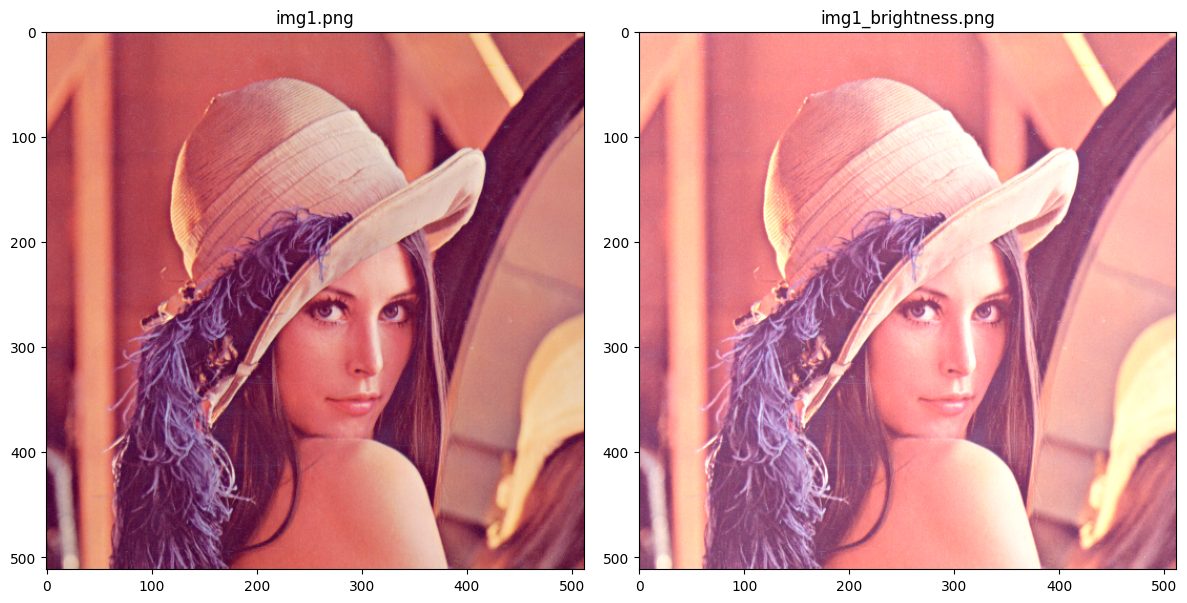

In [12]:
def main():
  # Nhập vào tên file ảnh.
  img_path = input("Enter the name of the image file: ")
  #img_path = 'image.jpg'
  
  print("0. Do it all. \n1. Adjust brightness. \n2. Adjust contrast \n3. Flip image (vertical or horizontal) \n4. Convert to grayscale \n5. Convert to sepia \n6. Sharpen images \n7. Blur image \n8. Crop at center \n9. Circular mask \n10. Elipse mask \n11. Exit")
  choice = int(input("Enter the choice:"))
  #choice = 0
  showResult(img_path, choice)
 

main()